### Unit 2 Lesson 3.4 Challenge: Iterate and evaluate your classifier


It's time to revisit your classifier from the previous assignment. Using the evaluation techniques we've covered here, look at your classifier's performance in more detail. Then go back and iterate by engineering new features, removing poor features, or tuning parameters. Repeat this process until you have five different versions of your classifier. Once you've iterated, answer these questions to compare the performance of each:

- Do any of your classifiers seem to overfit?
- Which seem to perform the best? Why?
- Which features seemed to be most impactful to performance?


Write up your iterations and answers to the above questions in a few pages. Submit a link below and go over it with your mentor to see if they have any other ideas on how you could improve your classifier's performance.


### Validation at bottom 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

In [3]:
#file = './sentiment labelled sentences copy/yelp_labelled.txt'
file = './sentiment labelled sentences copy/amazon_cells_labelled.txt'

sms_raw = pd.read_csv(file, delimiter= '\t', header=None)
sms_raw.columns = ['review', 'label']
sms_raw['simple_text'] = sms_raw['review'].str.lower()
sms_raw['simple_text'] = sms_raw['simple_text'].str.replace(".", " ")
sms_raw['simple_text'] = sms_raw['simple_text'].str.rstrip('.!? \n\t')
sms_good = sms_raw
sms_bad = sms_raw.loc[:, ['label', 'simple_text']]
sms_raw.head()

,review,label,simple_text
0,So there is no way for me to plug it in here i...,0,so there is no way for me to plug it in here i...
1,"Good case, Excellent value.",1,"good case, excellent value"
2,Great for the jawbone.,1,great for the jawbone
3,Tied to charger for conversations lasting more...,0,tied to charger for conversations lasting more...
4,The mic is great.,1,the mic is great


## 1. Review length 

In [4]:
sms_raw['length'] = sms_raw['simple_text'].str.len()
## alternative method: 
# sms_raw['length2'] = sms_raw.review.apply(len)
bad = sms_raw.loc[sms_raw['label'] == 0]
good = sms_raw.loc[sms_raw['label'] != 0]

length1 = bad['review'].str.len()
length2 = good['review'].str.len()
print("bad review average length: {}, good review averge length: {}".format(length1.mean(), length2.mean()))

bad review average length: 56.824, good review averge length: 53.628


- No real difference in average length between positive and negative reviews

In [5]:
sms_raw.loc[0:4, ['label','simple_text',  'length']]

,label,simple_text,length
0,0,so there is no way for me to plug it in here i...,81
1,1,"good case, excellent value",26
2,1,great for the jawbone,21
3,0,tied to charger for conversations lasting more...,77
4,1,the mic is great,16


## 2. Keyword Analysis

#### Determining which keywords are most present in the data:

In [6]:
## Keyword Significance Test

possible_words = ['good', 'loved', 'great', 'five', 'superb', 
                 'quick', 'delicous', 'delightful', 'liked', 'fun', 'enjoyed', 'again', 
                 'happy', 'not', 'bad', 'unhappy', 'wasted', 'underwhelming', 'gone'
                 'shouldn\'t', 'should', 'disappointed', 'found', 'else', 
                 'problem', 'lacked', 'bit', 'below', 'average', 'nasty', 'unfortunately', 'no problem']

cache = {}

for i in possible_words:
    x = 0
    for j in sms_raw['simple_text']:
        if i in j:
            x+=1
            cache.update({i : x})
sorted(cache.items(),  key = lambda x:x[1], reverse=True)

[('not', 129),
 ('great', 98),
 ('good', 75),
 ('problem', 25),
 ('happy', 17),
 ('bad', 14),
 ('again', 12),
 ('fun', 10),
 ('disappointed', 10),
 ('found', 8),
 ('quick', 7),
 ('should', 6),
 ('no problem', 5),
 ('unfortunately', 4),
 ('bit', 3),
 ('below', 3),
 ('superb', 2),
 ('unhappy', 2),
 ('wasted', 2),
 ('else', 2),
 ('loved', 1),
 ('five', 1),
 ('liked', 1),
 ('average', 1)]

### Feature Engineering a continous variable for 'good' and 'bad' keywords 

process:
- From list of key words, create categorical variable for each word based on it's presense in the review

- Change the Boolean(Categorical) var into a 1 or 0

- Sum the number of present keywords 

- Concatinate results into final dataframe

In [7]:
good_words = ['good', 'great', 'again', 'happy', 'quick', 'fun', 'enjoyed', 'liked', 'delightful', 'love']
for key in good_words:
    sms_good[str(key)] = sms_good.simple_text.str.contains(
        str(key),
        )
    
sms_good[0:5]

,review,label,simple_text,length,good,great,again,happy,quick,fun,enjoyed,liked,delightful,love
0,So there is no way for me to plug it in here i...,0,so there is no way for me to plug it in here i...,81,False,False,False,False,False,False,False,False,False,False
1,"Good case, Excellent value.",1,"good case, excellent value",26,True,False,False,False,False,False,False,False,False,False
2,Great for the jawbone.,1,great for the jawbone,21,False,True,False,False,False,False,False,False,False,False
3,Tied to charger for conversations lasting more...,0,tied to charger for conversations lasting more...,77,False,False,False,False,False,False,False,False,False,False
4,The mic is great.,1,the mic is great,16,False,True,False,False,False,False,False,False,False,False


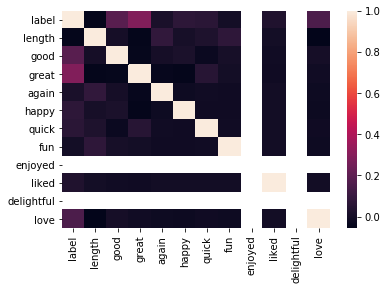

In [8]:
## extra: looks like good and great have a larger impact on the label
# sms_good['label'] = (sms_good['label'] == 1)
sns.heatmap(sms_good.corr())

In [9]:
replaced_bool = sms_good.loc[:, 'good':'love'].apply(np.ceil, axis = 1)
replaced_bool['g_sum'] = replaced_bool.apply(sum, axis = 1)
x = replaced_bool['g_sum']
x
y = sms_good.loc[:, 'label': 'length']
z = pd.concat([y, x], axis = 1)
z.head()

,label,simple_text,length,g_sum
0,0,so there is no way for me to plug it in here i...,81,0.0
1,1,"good case, excellent value",26,1.0
2,1,great for the jawbone,21,1.0
3,0,tied to charger for conversations lasting more...,77,0.0
4,1,the mic is great,16,1.0


In [10]:
bad_words = ['not', 'disappointed', 'bad', 'should', 'else', 'unfortunately', 'lacked']
for key in bad_words:
    sms_bad[str(key)] = sms_bad.simple_text.str.contains(
        str(key),
        )
    
sms_bad[0:5]

,label,simple_text,not,disappointed,bad,should,else,unfortunately,lacked
0,0,so there is no way for me to plug it in here i...,False,False,False,False,False,False,False
1,1,"good case, excellent value",False,False,False,False,False,False,False
2,1,great for the jawbone,False,False,False,False,False,False,False
3,0,tied to charger for conversations lasting more...,False,False,False,False,False,False,False
4,1,the mic is great,False,False,False,False,False,False,False


In [11]:
replaced_bool = sms_bad.loc[:, 'not':'lacked'].apply(np.ceil, axis = 1)
replaced_bool['b_sum'] = replaced_bool.apply(sum, axis = 1)
x = replaced_bool['b_sum']
y = sms_bad.loc[:,  'label':'simple_text']
z2 = pd.concat([y, x], axis = 1)

In [12]:
b = z2.loc[:, ['b_sum']]
df = pd.concat([z, b], axis = 1)

### Final dataframe:

Includes the label, initial text, along with sum of good and words present in each review

In [13]:
df.head()

,label,simple_text,length,g_sum,b_sum
0,0,so there is no way for me to plug it in here i...,81,0.0,0.0
1,1,"good case, excellent value",26,1.0,0.0
2,1,great for the jawbone,21,1.0,0.0
3,0,tied to charger for conversations lasting more...,77,0.0,0.0
4,1,the mic is great,16,1.0,0.0


In [14]:
#df['label'] = (df['label'] == 0)
#sns.heatmap(df.corr())

In [15]:
#df['label'] = (df['label'] == 1)
#sns.heatmap(df.corr())

## 3. Stop Words

### Significance (same as keywords)

In [16]:
stpwrds = set(stopwords.words('english'))
# nltk.download()
# stpwrds

cache = {}

for i in stpwrds:
    x = 0 
    h = ' '+ i + ' '
    for j in sms_raw['simple_text']:
        if h in j: 
            x += 1
            cache.update({i : x})
sorted(cache.items(), key = lambda x :x[1], reverse=True)            

[('the', 310),
 ('and', 267),
 ('is', 204),
 ('a', 185),
 ('to', 168),
 ('it', 157),
 ('i', 156),
 ('this', 142),
 ('my', 115),
 ('of', 112),
 ('for', 108),
 ('with', 103),
 ('not', 96),
 ('on', 85),
 ('in', 82),
 ('was', 77),
 ('very', 77),
 ('have', 69),
 ('that', 67),
 ('you', 45),
 ('had', 43),
 ('but', 40),
 ('are', 37),
 ('has', 33),
 ('as', 33),
 ('from', 33),
 ('so', 33),
 ('your', 31),
 ('all', 28),
 ('than', 28),
 ('be', 26),
 ('only', 22),
 ('or', 22),
 ('up', 21),
 ('no', 21),
 ('at', 21),
 ('when', 20),
 ('any', 19),
 ('am', 19),
 ('out', 19),
 ('me', 19),
 ('after', 19),
 ('about', 18),
 ('can', 18),
 ('does', 17),
 ('an', 17),
 ('because', 17),
 ('if', 17),
 ("don't", 16),
 ('just', 16),
 ('been', 15),
 ('few', 14),
 ('then', 14),
 ('do', 14),
 ('which', 14),
 ('will', 13),
 ('these', 13),
 ('did', 13),
 ('more', 13),
 ("it's", 13),
 ('now', 12),
 ('too', 12),
 ('while', 12),
 ('there', 11),
 ("doesn't", 11),
 ('over', 10),
 ('into', 10),
 ('other', 10),
 ('same', 10),
 

#### Removable words

In [17]:
## Future: write function that takes key from dictionary and creates this list
removable_words = ['the', 'and', 'was', 'a', 'to', 'is', 'i', 'of', 'not', 'for', 'in', 'this'
                  'it', 'with', 'be', 'had', 'very', 'have', 'are', 'so', 'were', 'that', 'but', 'at', 'my', 'on', 'you',
                   'we', 'they', 'here', 'our', 'just', 'will', 'all', 'an', 'as', 'your', 'only', 
                   'there', 'their', 'been', 'out', 'or', 'from', 'which', 'by', 'about', 'some', 'more', 'did', 
                   'has', 'what', 'if', 'when', 'because', 'other', 'being', 'than', 'how', 'me', 'he',
                   'them', 'do', 'too',]
start = sms_raw.loc[:, ['simple_text']]

In [18]:
start.head()

,simple_text
0,so there is no way for me to plug it in here i...
1,"good case, excellent value"
2,great for the jawbone
3,tied to charger for conversations lasting more...
4,the mic is great


In [19]:
for key in removable_words:
    start[str(key)] = start.simple_text.str.contains(
        str(key),
        )
    
start[0:5]

,simple_text,the,and,was,a,to,is,i,of,not,...,because,other,being,than,how,me,he,them,do,too
0,so there is no way for me to plug it in here i...,True,False,False,True,True,True,True,False,False,...,False,False,False,False,False,True,True,False,False,False
1,"good case, excellent value",False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,great for the jawbone,True,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,tied to charger for conversations lasting more...,False,False,False,True,True,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
4,the mic is great,True,False,False,True,False,True,True,False,False,...,False,False,False,False,False,False,True,False,False,False


In [20]:
replaced_bool = start.loc[:, 'the':'too'].apply(np.ceil, axis = 1)
replaced_bool['stop_words_sum'] = replaced_bool.apply(sum, axis = 1)


In [21]:
replaced_bool.head()

,the,and,was,a,to,is,i,of,not,for,...,other,being,than,how,me,he,them,do,too,stop_words_sum
0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,15.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,7.0
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0
4,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0


In [22]:
x = replaced_bool['stop_words_sum']
df1 = pd.concat([df,x], axis=1 )

In [23]:
df1.describe()

,label,length,g_sum,b_sum,stop_words_sum
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.50000,54.149000,0.244000,0.165000,8.822000
std,0.50025,34.701369,0.463334,0.394881,4.574193
min,0.00000,9.000000,0.000000,0.000000,0.000000
25%,0.00000,25.000000,0.000000,0.000000,5.000000
50%,0.50000,46.500000,0.000000,0.000000,9.000000
75%,1.00000,76.000000,0.000000,0.000000,12.000000
max,1.00000,148.000000,3.000000,2.000000,24.000000


In [24]:
def funct(val):
    if val > 10:
        return 1
    else: 
        return 0   
df1['tilt'] = df1.loc[:, 'stop_words_sum'].apply(funct)

In [25]:
df1

,label,simple_text,length,g_sum,b_sum,stop_words_sum,tilt
0,0,so there is no way for me to plug it in here i...,81,0.0,0.0,15.0,1
1,1,"good case, excellent value",26,1.0,0.0,2.0,0
2,1,great for the jawbone,21,1.0,0.0,7.0,0
3,0,tied to charger for conversations lasting more...,77,0.0,0.0,12.0,1
4,1,the mic is great,16,1.0,0.0,6.0,0
5,0,i have to jiggle the plug to get it to line up...,73,0.0,0.0,8.0,0
6,0,if you have several dozen or several hundred c...,110,1.0,0.0,14.0,1
7,1,if you are razr owner you must have this,42,0.0,0.0,7.0,0
8,0,"needless to say, i wasted my money",34,0.0,0.0,7.0,0
9,0,what a waste of money and time,30,0.0,0.0,11.0,1


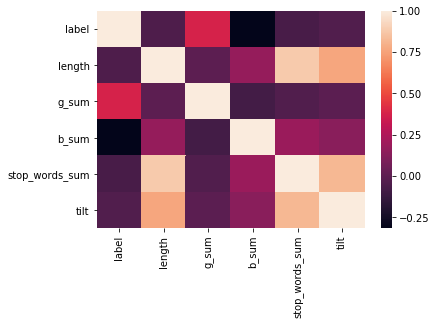

In [26]:
#df1['label'] = (df1['label'] == 1)
sns.heatmap(df1.corr())

In [27]:
df1.describe()

,label,length,g_sum,b_sum,stop_words_sum,tilt
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.50000,54.149000,0.244000,0.165000,8.822000,0.364000
std,0.50025,34.701369,0.463334,0.394881,4.574193,0.481389
min,0.00000,9.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,25.000000,0.000000,0.000000,5.000000,0.000000
50%,0.50000,46.500000,0.000000,0.000000,9.000000,0.000000
75%,1.00000,76.000000,0.000000,0.000000,12.000000,1.000000
max,1.00000,148.000000,3.000000,2.000000,24.000000,1.000000


## Modeling

In [28]:
data = df1.loc[:, 'length':'tilt']
target = df1['label']

In [29]:
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 326


In [30]:
(1000 - 348) / 1000

0.652

## Validiation


In [31]:
from sklearn.metrics import confusion_matrix
confusion_matrix(target, y_pred)

array([[482,  18],
       [308, 192]])

In [33]:
x = confusion_matrix(target, y_pred)

sensitivity = x[0,0]/(x[0,0] + x[0,1])
specificity = x[1,1]/(x[1,0] + x[1,1])
print('the sensitivity is {}, and the SPECIFICITY = {}'.format(sensitivity, specificity))

the sensitivity is 0.964, and the SPECIFICITY = 0.384


Based on the sensitivity, my model would benefit most from feature enginners towards identifying negative reviews. 
it is already very good at identifying good reviews. 



In [34]:
from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(bnb.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(bnb.fit(data, target).score(data, target)))



With 20% Holdout: 0.66
Testing on Sample: 0.674


The consistency of my model suggests none of my features are over fitting. 

In [35]:
from sklearn.model_selection import cross_val_score
cross_val_score(bnb, data, target, cv=10)

array([0.71, 0.68, 0.74, 0.68, 0.59, 0.71, 0.6 , 0.64, 0.72, 0.62])

Although generally consistent, this hold out cross validation suggests not all my features are having an equal affect on classification. 